In [1]:
############ Calculate Horizon Distances #################
import pycbc.psd
import numpy

from pycbc.waveform import get_fd_waveform
from pycbc.filter import sigma
from pycbc.cosmology import redshift

import tqdm

dur = 32
sr = 10000
flow = 5.05
df = 1.0 / dur
tlen = sr * dur
flen = tlen // 2 + 1

det_masses = numpy.logspace(-1, 3.6, 300)

############# CE designs noise ###################################

ce_40k_lf_hp = pycbc.psd.from_txt("ce_strain/cosmic_explorer_40km_lf_hp_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)

ce_40k_det = pycbc.psd.from_txt("ce_strain/cosmic_explorer_40km_lf_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)

ce_40k_base = pycbc.psd.from_txt("ce_strain/cosmic_explorer_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)

ce_20k_base = pycbc.psd.from_txt("ce_strain/cosmic_explorer_20km_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)


ce_20k_pm = pycbc.psd.from_txt("ce_strain/cosmic_explorer_20km_pm_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)


aplus = pycbc.psd.from_txt("ligo_strain/AplusDesign.txt",
                                 flen, df, flow,
                                 is_asd_file=True)

asharp = pycbc.psd.from_txt("ligo_strain/Asharp_strain.txt",
                                 flen, df, flow,
                                 is_asd_file=True)
   
    
ce_psds = {'CE:LowFreqHighPower':ce_40k_lf_hp,
           'CE:LowFreq':ce_40k_det,
           'CE:Broad': ce_40k_base, 
           'CE:20km': ce_20k_base,
           'CE:20kmPostmerger': ce_20k_pm,
           'A+':aplus,
           'A#':asharp,
          }
############ read in noise budget ###################
import numpy
from pycbc.types import FrequencySeries

noise = numpy.genfromtxt('ce_strain/CEnoisebudget.csv', delimiter=',', names=True)

names = list(noise.dtype.names)
names.remove('Frequency')

freq = noise['Frequency']

f = numpy.arange(0, 6000, df)

noise_psds = {}

for t in names:
    noise_psds[t] = FrequencySeries(numpy.interp(f, freq, noise[t]), delta_f=df)
    

noise_psds['FacilityLimit'] = noise_psds['Newtonian'] + noise_psds['ExcessGas']

################ get horizons distance ##################
signal_amp_limit = {k: [] for k in noise_psds}
signal_amp = {k: [] for k in ce_psds}
for m in tqdm.tqdm(det_masses):
    hp, hc = get_fd_waveform(approximant="IMRPhenomXPHM",
                             mass1=m,
                             mass2=m,
                             f_lower=flow,
                             delta_f=df,
                             f_final=2048,
                             )
    for k in noise_psds:
        hp.resize(len(noise_psds[k]))
        amp = sigma(hp, psd=noise_psds[k]**2.0, low_frequency_cutoff=flow)
        signal_amp_limit[k].append(amp)
        
    for k in ce_psds:
        p = ce_psds[k]
        hp.resize(len(p))
        amp = sigma(hp, psd=p, low_frequency_cutoff=flow)
        signal_amp[k].append(amp)

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:34<00:00,  8.72it/s]


In [2]:
########### Generate Populations ################
from pycbc.distributions import draw_samples_from_config
import os.path
import numpy.random
import h5py

if os.path.exists('./_population_saved.hdf'):
    f = h5py.File('./_population_saved.hdf', 'r')
    bns = f['bns'][:]
    bbh = f['bbh'][:]
else:
    bns = draw_samples_from_config('populations/bns.ini', int(1e6))
    bbh = draw_samples_from_config('populations/bbh.ini', int(1e5))
    f = h5py.File('./_population_saved.hdf', 'w')
    f['bns'] = bns
    f['bbh'] = bbh
    
#fiducial nsbh population
nsbh = {}
nsbh['redshift'] = bns['redshift'][0:50000] # close enough...
nsbh['mass'] = numpy.random.lognormal(numpy.log(10), 0.25, size=len(nsbh['redshift']))

In [3]:
# Generate fiducial pop III population
import numpy.random
psize = 200
popthree = {}
popthree['redshift'] = numpy.random.normal(17, 5, size=psize)
popthree['mass'] = numpy.random.lognormal(numpy.log(55), 0.9, size=psize)

# quick and dirty eyeball from here temporarily 2303.15515.pdf

In [4]:
# Generate fiducial  QCD Phase transition PBHs
import numpy.random
psize = 5000
pbh = {}
pbh['mass'] = numpy.random.normal(0.7*2.0, 1.0, size=psize)
pbh['mass'] = numpy.concatenate([pbh['mass'], numpy.random.lognormal(0.7*1.2, 1.5, size=psize)])
pbh['redshift'] = numpy.log(numpy.random.uniform(0, numpy.e**0.25, size=len(pbh['mass'])))*1200 * 6.0 / 3.0

In [41]:
################################# Post merger SNR calculation ##########################
######


from pycbc.types import TimeSeries
from pycbc.waveform import get_td_waveform
from watpy.wave.wave import wave

mass = 2.700297e+00
f0 = 3.789461e-2 / numpy.pi / 2.0 / mass

f0Hz = f0 / 4.925794970773135e-06 
w = wave(path="../watpy/tutorials/TestData/MySim_BAM_135135/",
         code='bam',
         filename='Rpsi4mode22_r12.l0', 
         mass = mass, 
         f0 = f0,
         )
x = w.get_strain(fcut=f0)
t = w.time * 4.925794970773135e-06 
scale = 1e-20 * 3.5
bns = TimeSeries(x.real, delta_t=t[1]-t[0]) * scale
peak_time = bns.sample_times[bns.abs_arg_max()]
bns.start_time = - peak_time

hp, hc = get_td_waveform(approximant="TaylorF2",
                         mass1=1.4, mass2=1.4,
                         f_lower=f0Hz, delta_t=1.0/8192,
                        )

#plt.figure()
#hp.plot() 
#plt.xlim(-0.01, 0.01)
#bns.plot()

# made by visual inspection
post_merger = bns.time_slice(0.0006, bns.end_time)
#post_merger.plot()

from pycbc.conversions import mchirp_from_mass1_mass2
mref = mchirp_from_mass1_mass2(mass, mass)

def postmerger(dist):
    z = redshift(dist)
    fac = 1 / dist
    hp = post_merger * fac
    hp._delta_t *= (1 + z)
    return hp, z

def snr_minim(dist, p, snr_target):
    dist = dist[0]
    hp, z = postmerger(dist)
    sig = hp.to_frequencyseries(p.delta_f)
    sig.resize(len(p))
    snr = sigma(sig, psd=p, low_frequency_cutoff=2000 / (1 + z), high_frequency_cutoff=4500 / (1 + z))
    #print(snr,  dist, abs(snr - snr_target))
    #print(snr_target, snr, dist, abs(snr - snr_target))
    return abs(snr - snr_target)

################ get horizons distance ##################
from scipy.optimize import minimize
for k in ce_psds:
    p = ce_psds[k]
    
    x = minimize(snr_minim, 10, bounds=[(10, 1000)], args=(p, 8.0), tol=0.01)
    print("'%s': %s" % (k, x['x'][0]))
    
    #print(k, snr_minim([200], p, 8.0))

KeyboardInterrupt: 

In [5]:
!wget -nc -O PEtable.txt https://github.com/gwastro/4-ogc/raw/master/posterior/PEtable.txt
    
import numpy
catalog = numpy.genfromtxt("./PEtable.txt", delimiter=',', skip_header=1)
cat_mtotal = catalog[:,1] + catalog[:, 4]
cat_redshift = catalog[:,19]

File ‘PEtable.txt’ already there; not retrieving.


In [6]:
# Switf grbs from https://swift.gsfc.nasa.gov/archive/grb_table.html/table.php?obs=Swift&year=All+Years&restrict=redshifts&redshift=1&bat_t90=1
import numpy
import re
grbs = numpy.genfromtxt("./grb_table_1683581796.txt", delimiter='\t', skip_header=1, dtype=str)
t90 = grbs[:,1]
gredshift = grbs[:,2]
grb_z = []
for r, t in zip(gredshift, t90):
    try:
        if float(t) < 2.0:
            grb_z.append(float(re.findall("\d+\.\d+", r)[0]))
    except ValueError:
        continue

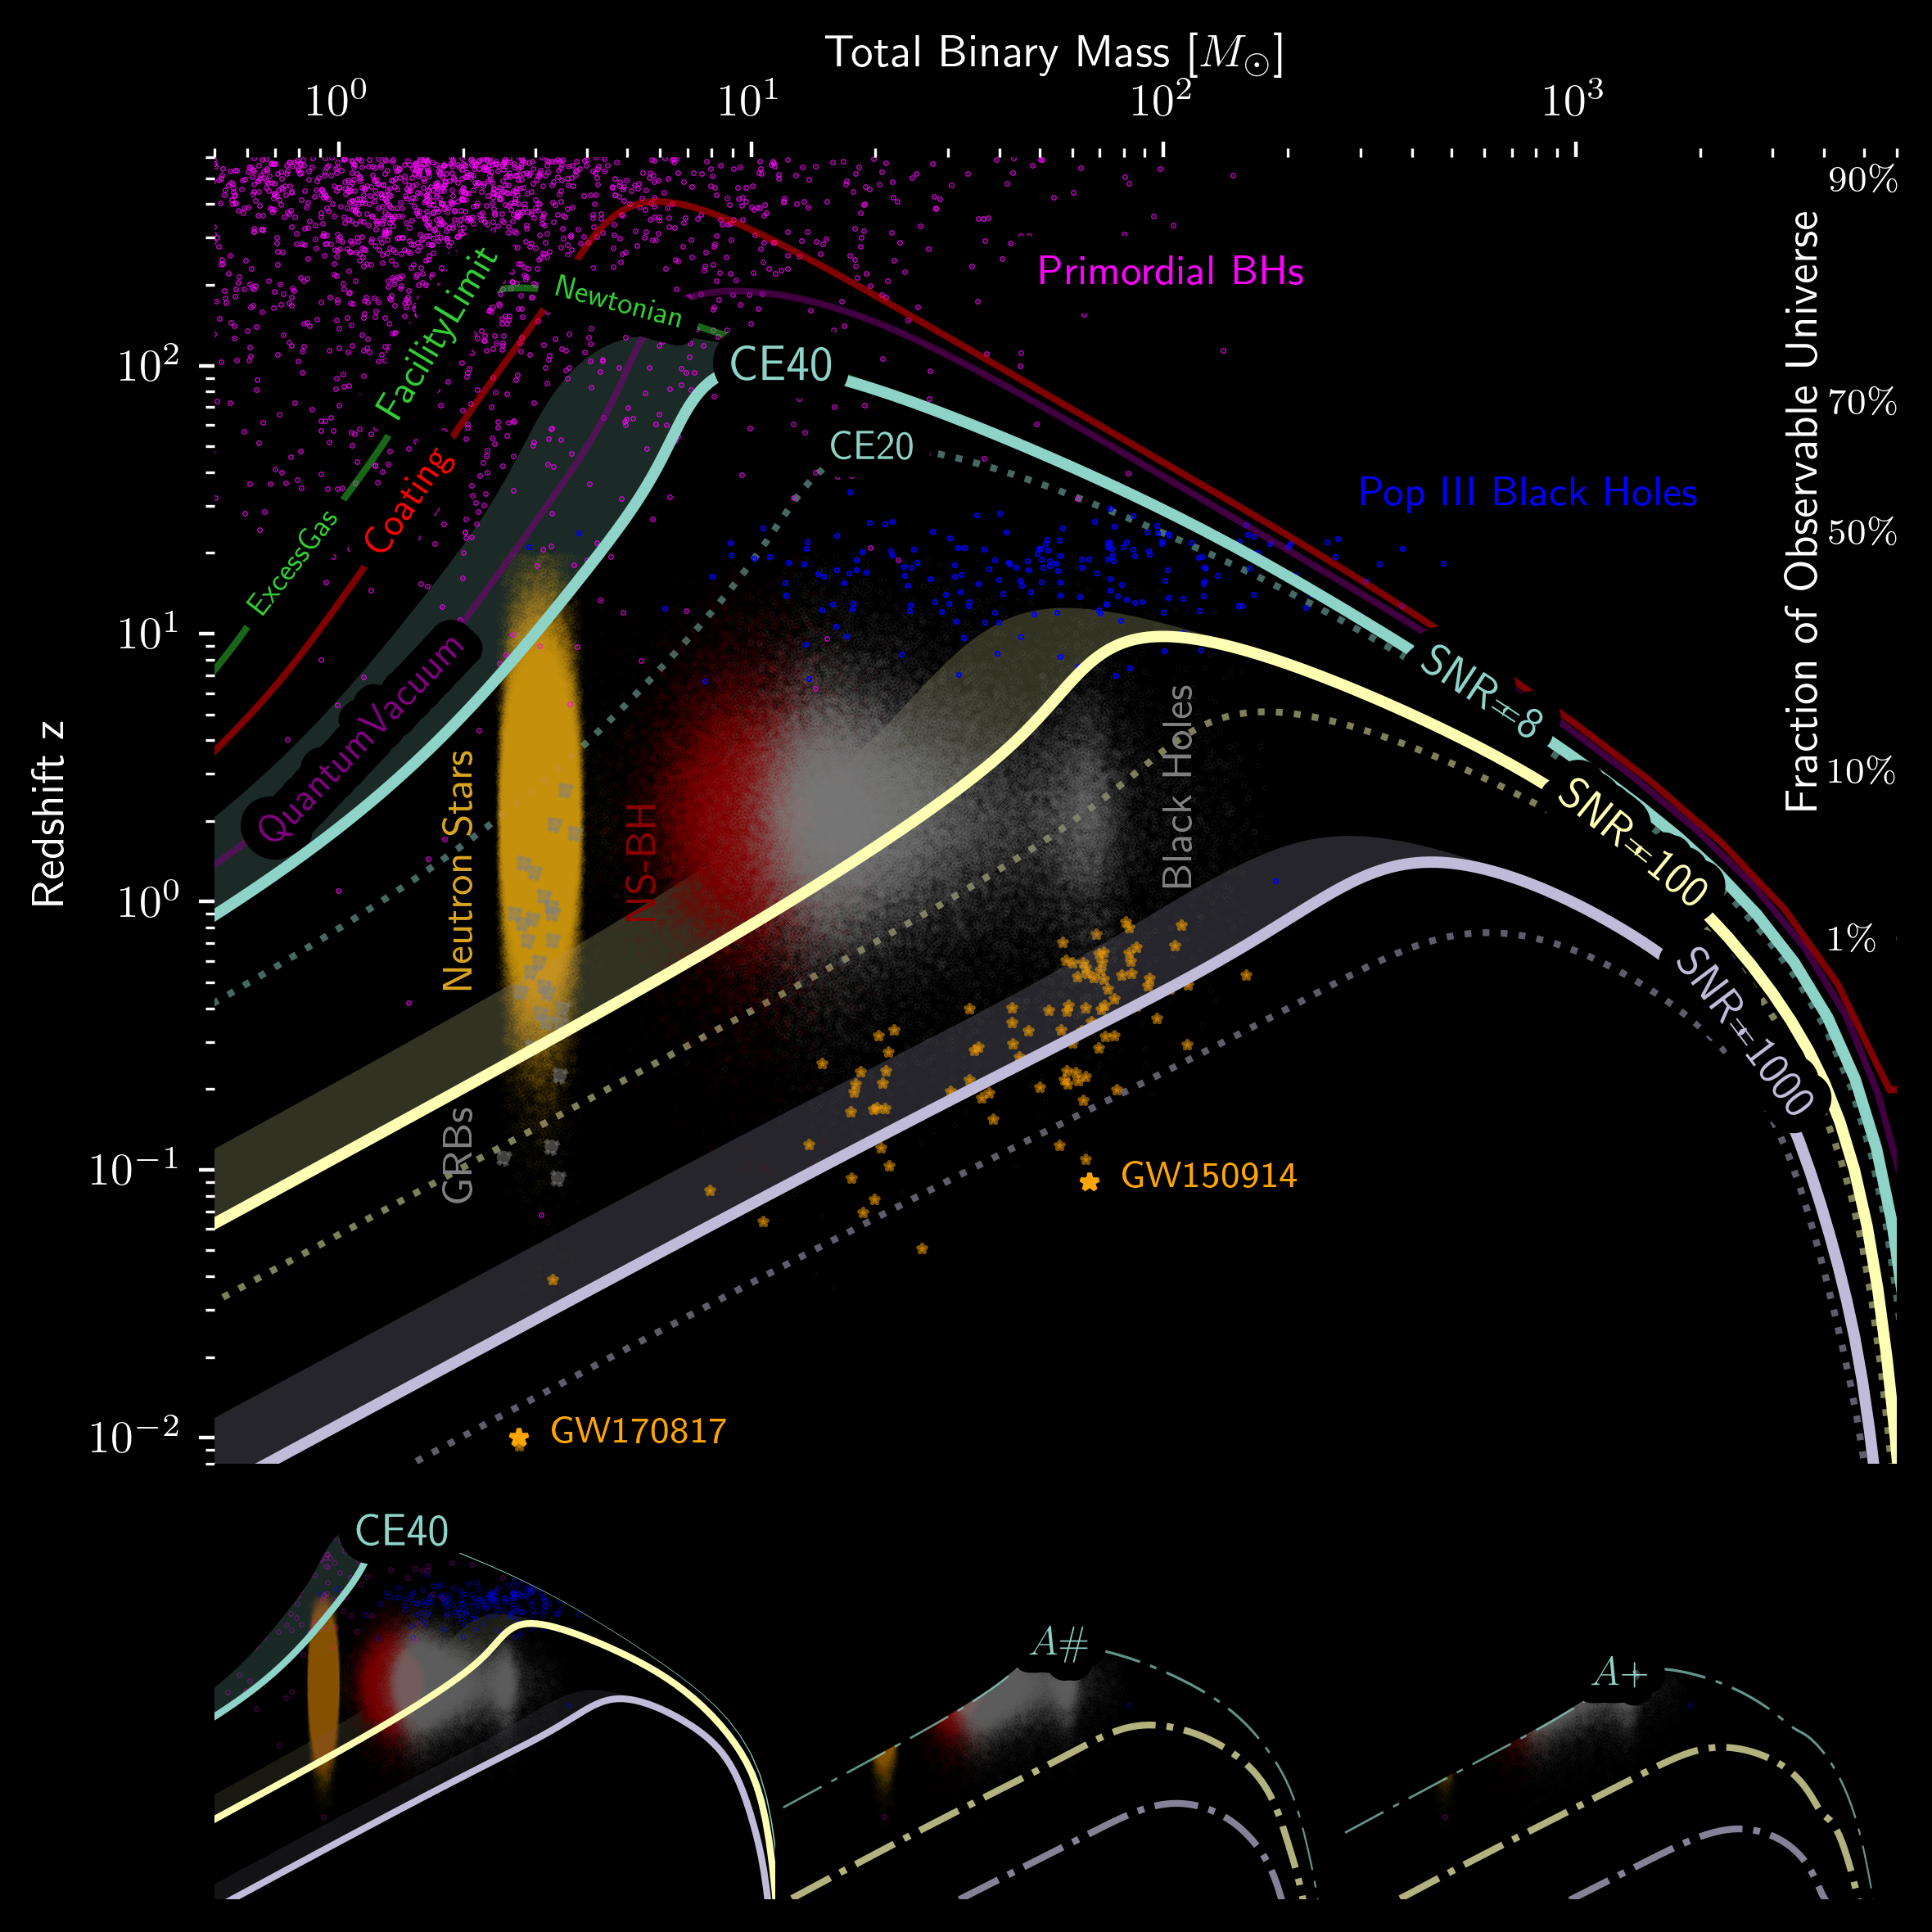

In [18]:
# Make plot ##########
import matplotlib.pyplot as plt
from matplotlib import ticker
from labellines import labelLine, labelLines, labelLine
from scipy.interpolate import interp1d

style = 'whi'
if style == 'white':
    plt.style.use('default')
    print('style')
    bgcolor = 'white'
    hcolor = 'grey'
    bhcolor = 'black'
else:
    plt.style.use('dark_background')
    bgcolor = 'black'
    hcolor = 'black'
    bhcolor = 'grey'

fig = plt.figure(figsize=[6, 6], dpi=400)
gs = plt.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[3, 1], wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,:])
ax2 = [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]), fig.add_subplot(gs[1,2])]
axs = [ax, ax2[0], ax2[1], ax2[2]]


plt.rc('text', usetex=True)

axs[0].set_ylabel('Redshift z')
axs[0].set_xlabel('Total Binary Mass [$M_\odot$]')
axs[0].xaxis.tick_top()
axs[0].xaxis.set_label_position('top') 

for ax in axs:
    ax.set_ylim(0.008, 600)
    ax.set_xlim(0.5, 6000)
    #plt.xlim(1, 300)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
for ax in ax2:
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

#axs[0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2g'))
    
####### Secondary y axis #################################
import astropy.cosmology

cosmo = astropy.cosmology.Planck15
maxvol = cosmo.comoving_volume(1e6)
zref = numpy.arange(0, 10000, 1)
frac = cosmo.comoving_volume(zref) / maxvol

def forward(z):
    return numpy.interp(z, zref, frac)

def inverse(z):
    return numpy.interp(z, frac, zref)

ax2 = axs[0].secondary_yaxis('right', functions=(forward, inverse))
ax2.set_ylabel('Fraction of Observable Universe',
               labelpad=-25, horizontalalignment='left')
ax2.xaxis.set_label_coords(.9, 0.65)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().get_major_formatter().labelOnlyBase = False
ax2.tick_params(axis="y",direction="in", pad=-15)
ax2.set_yticks([.01, .1, .5, .7, .90])
ax2.set_yticklabels([ "$1\\%$", "$10\\%$", "$50\\%$", "$70\\%$", "$90\\%$"],
                    backgroundcolor=bgcolor, zorder=999, fontsize=8)
ax2.minorticks_off()


# add horizon distance lines ####################################

snrs = [8, 100, 1000]
pos = [600, 1400, 2600]
ltext = ["BH \& NS Throughout Cosmic Time",
         "Fundamental physics from rare obs.",
         "Precision NS Dense Matter and GR"]
ltextpos = [100, 30, 10]
for snr, alpha, spos, lt, ltp in zip(snrs, [1, 0.5, 0.5, 0.5],
                                     pos, ltext, ltextpos):
    # 40k
    z = redshift(numpy.array(signal_amp['CE:Broad']) / snr)
    src_mass = det_masses * 2.0 / (1 + z) 
    p1 = axs[0].plot(src_mass, z, alpha=1.0, linestyle='-', linewidth=2.5, zorder=999)
    i1 = interp1d(src_mass, z, fill_value='extrapolate')

    # 40k HP PM
    z = redshift(numpy.array(signal_amp['CE:LowFreqHighPower']) / snr)
    src_mass = det_masses * 2.0 / (1 + z) 
    i2 = interp1d(src_mass, z, fill_value='extrapolate')
    p3 = axs[0].plot(src_mass, (i1(src_mass) + i2(src_mass)) / 2.0, 
                     linestyle='dashed', color=p1[-1].get_color(), alpha=0,
                     zorder=-1)
    axs[0].fill_between(src_mass, i1(src_mass), i2(src_mass),
                        color=p1[-1].get_color(),
                        zorder=-1, alpha=0.2, edgecolor="none",)
    
    
    p100 = axs[1].plot(src_mass, i1(src_mass), alpha=1.0, linestyle='-')
    axs[1].fill_between(src_mass, i1(src_mass), i2(src_mass),
                        color=p1[-1].get_color(),
                        zorder=-1, alpha=0.1, edgecolor="none",)
    if snr == snrs[0]:
        axs[1].fill_between(src_mass, i1(src_mass), i2(src_mass),
                            color=p1[-1].get_color(),
                            zorder=-1, alpha=0.1, edgecolor="none",)
        axs[1].fill_between(src_mass, i2(src_mass), 1000, color=hcolor, zorder=999)  
        
        
    # 20k
    z = redshift(numpy.array(signal_amp["CE:20km"]) / snr)
    src_mass = det_masses * 2.0 / (1 + z)   
    p40 = axs[0].plot(src_mass, z, 
            color=p1[-1].get_color(), alpha=0.5, linestyle='dotted', zorder=-1)

    # A+
    z = redshift(numpy.array(signal_amp["A+"]) / snr)
    src_mass = det_masses * 2.0 / (1 + z)    
    p6 = axs[3].plot(src_mass, z, 
            color=p1[-1].get_color(), linestyle='dashdot', alpha=0.7)
    if snr == snrs[0]:
        axs[3].fill_between(src_mass, z*1.05, 1000, color=hcolor, zorder=10)       
    
    # A#
    z = redshift(numpy.array(signal_amp["A#"]) / snr)
    src_mass = det_masses * 2.0 / (1 + z)    
    p7 = axs[2].plot(src_mass, z, 
            color=p1[-1].get_color(), linestyle='dashdot', alpha=0.7)
    if snr == snrs[0]:
        axs[2].fill_between(src_mass, z*1.05, 1000, color=hcolor, zorder=999)       
    
    
    if snr == snrs[0]:
        labelLine(p1[0], 12, label='CE40', align=False, fontsize=11, zorder=1000)
        labelLine(p100[0], 12, label='CE40', align=False, fontsize=10, zorder=1000)
        labelLine(p40[0], 20, label='CE20', align=False, fontsize=9, zorder=1000)
        labelLine(p6[0], 60, label='$A+$', align=False, fontsize=9, zorder=10000)
        labelLine(p7[0], 60, label='$A\\#$', align=False, fontsize=9, zorder=1000)


    labelLine(p1[0], spos, label=f"SNR={snr}",
              fontsize=10, zorder=1000, alpha=1.0)
    
#labelLines(plt.gca().get_lines(), align=True, fontsize=10)

# add facility horizon limit ###################################

xvals = {'QuantumVacuum':1.2, 
         'ExcessGas':1.1,
         'Coating':1.5,
         'Substrate':40,
         'SuspensionThermal':1.3,
         'Newtonian':6,
         'FacilityLimit':1.8,
        }

colors = {'QuantumVacuum':'purple', 
         'ExcessGas':'limegreen',
          'Coating':'red',
         'Newtonian':'darkgreen',
          'FacilityLimit': 'limegreen'
        }

for k in ['QuantumVacuum', 'Coating', 'FacilityLimit']:
    linestyle = '-'
    alpha = 0.5
    label = k
    if label == 'QauntumVacuum':
            lable = 'Quantum'
        
    ldist_horizon = numpy.array(signal_amp_limit[k]) / 8.0
    
    if k in xvals:
        xval = xvals[k]
    else:
        xval = 5

    z = redshift(ldist_horizon)
    src_mass = det_masses / (1 + z)
    axs[0].plot(src_mass * 2.0, z, label=label, linestyle=linestyle, alpha=alpha,
                color=colors[k])
    labelLine(axs[0].get_lines()[-1], xval,
              align=True, fontsize=9,
              alpha=1.0)
    
    if k == "FacilityLimit":
        labelLine(axs[0].get_lines()[-1], 0.8, 'ExcessGas',
              align=True, fontsize=7,
              alpha=1.0)
        labelLine(axs[0].get_lines()[-1], 5, 'Newtonian',
              align=True, fontsize=7,
              alpha=1.0)

# add interesting single events#################################
from pycbc.catalog import Merger

m = Merger("GW170817")
x, y = m.mass1 + m.mass2, m.redshift
axs[0].plot(x, y, '*', color='orange', markersize=4, zorder=10)
axs[0].text(x*1.2, y/1.05, 'GW170817', fontsize=8, color='orange', zorder=9)

m = Merger("GW150914")
x, y = m.mass1 + m.mass2, m.redshift
axs[0].plot(x, y, '*', color='orange', markersize=4, zorder=10)
axs[0].text(x*1.2, y/1.05, 'GW150914', fontsize=8, color='orange', zorder=9)
axs[0].scatter(cat_mtotal, cat_redshift, marker='*', 
               s=3,
               color='orange', alpha=0.5)

##################################################
# Add populations of events
for i, ax in enumerate(axs):
    fac = 1
    if i >= 1:
        fac =  (.33) ** 2
    ax.scatter(bns['srcmass1'] + bns['srcmass2'], bns['redshift'],
               s=0.001 * fac, rasterized=True, alpha=0.25, color='goldenrod')
    ax.scatter(bbh['srcmass1'] + bbh['srcmass2'], bbh['redshift'],
               s=0.001 * fac, rasterized=True, alpha=0.5, color=bhcolor)
    ax.scatter(popthree['mass'], popthree['redshift'], color='blue', s=0.1 * fac, alpha=1.0)
    
    ax.scatter(pbh['mass'], pbh['redshift'],
               color='magenta', s=0.15 * fac, alpha=1.0, marker='.', rasterized=True)

    ax.scatter(nsbh['mass'], nsbh['redshift'], 
               color='darkred', s=0.05 * fac,
               alpha=0.2, marker='.', zorder=-1, rasterized=True)


axs[0].text(1.8, .5, 'Neutron Stars', rotation=90, fontsize=9, color='goldenrod')
axs[0].text(5, .9, 'NS-BH', rotation=90, fontsize=9, color='darkred')
axs[0].text(100.0, 1.2, 'Black Holes', rotation=90, fontsize=9, color=bhcolor)
axs[0].text(300.0, 30, 'Pop III Black Holes', fontsize=9, color='blue')
axs[0].text(50, 200, 'Primordial BHs', fontsize=9,
            color='magenta', backgroundcolor=bgcolor)


############short grbs with redshift from Swift ########

axs[0].scatter((bns['srcmass1'] + bns['srcmass2'])[0:len(grb_z)],
               grb_z, color='grey', 
               linestyle='dotted', marker='.', alpha=0.5)
axs[0].text(1.8, 0.08, 'GRBs', fontsize=9, rotation=90,
            color='gray')

fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig('znb.pdf')